In [1]:
from exercise_1 import box3d, projectpoints
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from numba import jit 
import logging;
logging.disable(logging.WARNING)

In [2]:
@jit
def euclidean_distance(r):
    return np.sqrt(r[0]**2 + r[1]**2)

In [3]:
@jit
def radial_distort(p, dist):
    """
    Distorts the points in vector P, based on distortion coefficients dist.
        rd = r(1+dr)
        dr = k3||r||^2 + k5||r||^2 + ...
    
    dist holds the k3, k5, ... koefficients and p holds all all vectors.
    """
    dist_p = np.zeros(shape=(p.T).shape)
    i = 0
    for r in p.T:
        dr = 0
        j = 2
        for k in dist:
            dr += k*euclidean_distance(r)**j
            j+=2

        dist_p[i] = r*(1+dr)
        i+=1
    return dist_p.T

In [152]:
def projectpoints_2(K, R, t, Q, dist):
    """
    Projects 3D points of an object to the 2D image plane of the camera.
    Using homogenous coordinates the process can be done like this:
            p_h = K*[R t]*P_h

    Parameters:
        - K: camera matrix - hold intrinsic camera info like focault distance and principal points
        - R, t: pose of camera transformation; scale and transport object to the camera plane.
        - Q: 3xn the n 3D points to be projected onto image plane.
        - dist: distortion coefficients list.
    
    Returns: 2xn matrix of projected points
    """
    # First creates the [R t] Matrix
    A = np.hstack((R, t))
    # Then, translate Q to homogenous plane => 4xn matrix by adding s=1
    B = np.vstack((Q, np.ones(len(Q[0]))))
    C = A@B
    # Return to non-homogenous coordinates
    p = C[0:2, :]/C[2, :]
    # Distort the result
    p = radial_distort(p, dist)
    q = np.vstack((p, np.ones(len(p[0]))))
    # Multiply by the camera matrix
    q = K@q
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    return q[0:2, :]/q[2, :]

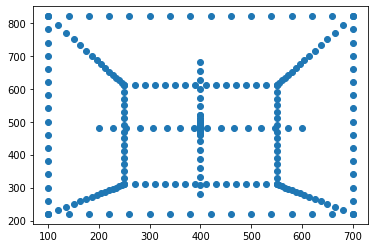

[[100.]
 [220.]]


In [146]:
# 2.1 Skew
Q = box3d(16)
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400
K = np.array([[f, f*beta, dx], [0, f*alpha, dy], [0, 0, 1]])
t = np.array([[0, 0.2, 1.5]]).T
R = np.identity(3)
p = projectpoints(K, R, t, Q)
plt.scatter(p[0,:], p[1,:])
plt.show()

# Where does the corner P_1 = [−0.5, −0.5, −0.5] project to? 
P_1 = np.asarray([[-0.5, -0.5, -0.5]]).T
p = projectpoints(K, R, t, P_1)
print(p) # [100, 220].T

# Does the object fit the image?
# => dx, dy = 400 => 800x800 image, so some values are outside now.

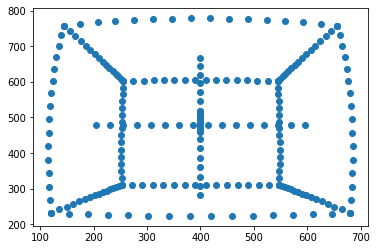

[[120.4 ]
 [232.24]]


In [153]:
# 2.2 Adding distortion
Q = box3d(16)
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400
K = np.array([[f, f*beta, dx], [0, f*alpha, dy], [0, 0, 1]])
t = np.array([[0, 0.2, 1.5]]).T
R = np.identity(3)
dist = np.array([-0.2])
#dist = np.array([-0.245031, 0.071524, -0.00994978])

p = projectpoints_2(K, R, t, Q, dist)
plt.scatter(p[0,:], p[1,:])
plt.show()

# Where does the corner P_1 = [−0.5, −0.5, −0.5] project to? 
P_1 = np.asarray([[-0.5, -0.5, -0.5]]).T
p = projectpoints_2(K, R, t, P_1, dist)
print(p) # [120.4, 232.24].T

# Now the image will entirely be captured do to negative distortion coefficient

### 2.3 Captured by gopro

1080 1920 3


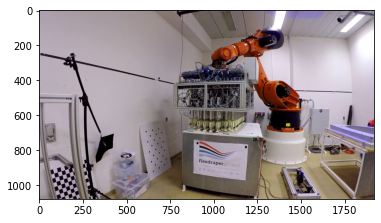

In [46]:
# Load image
img = cv2.imread('gopro_robot.jpg')
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
(h, w, d) = img.shape
print(h, w, d)

In [129]:
# The K matrix
f = int(0.455732 * w)
dx = int(0.5*h)
dy = int(0.5*w)
dist = np.array([-0.245031, 0.071524, -0.00994978])
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
print(K)

[[875   0 540]
 [  0 875 960]
 [  0   0   1]]


### 2.4 Undistort

In [154]:
import matplotlib.cm as cm

(1080, 1920)

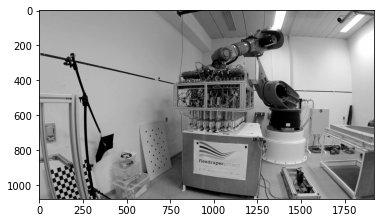

In [155]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap=cm.gray)
gray.shape

In [328]:

def undistortImage(gray, K, dist):
    """
    Undistorts an image by mapping the colors a new empty image.
    TODO: Assumes image is one single channel.
    """
    (height,width) = gray.shape
    ratio = height/width
    # Generate meshgrid of all pixels.
    y, x = np.meshgrid(
        np.linspace(-1, 1, num=width), np.linspace(-1*ratio, 1*ratio, num=height))
    x=x.flatten()
    y=y.flatten()
    mapping_matrix = np.vstack((x, y)).astype(float) # [x, y]

    # Distort the grid
    p = radial_distort(mapping_matrix, dist)

    q = np.vstack((p, np.ones(len(p[0]))))
    # Multiply by the camera matrix
    q = K@q
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    target_matrix = q[0:2, :]/q[2, :]

    # Target_matrix hold the distorted positions.
    canvas_matrix = np.zeros(shape=(int(height), int(width)), dtype=int)

    for i in range(height):
        for j in range(width):

            row = int(target_matrix[0][i*width + j]) 
            col = int(target_matrix[1][i*width + j])

            intensity = int(gray[row][col])
            canvas_matrix[i][j] = intensity




    return canvas_matrix

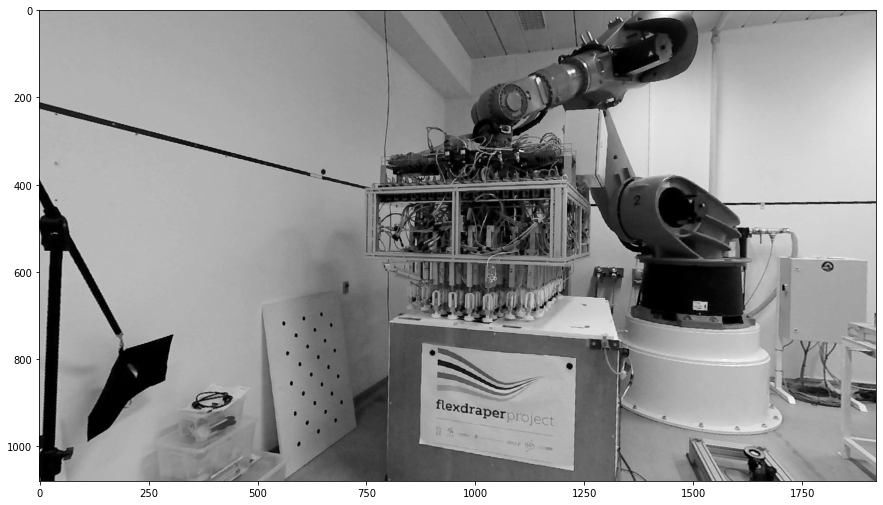

In [329]:
# The K matrix
(h, w) = gray.shape
f = int(0.455732 * w)
dx = int(0.5*h)
dy = int(0.5*w)
dist = np.array([-0.245031, 0.071524, -0.00994978])
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
canvas_matrix = undistortImage(gray, K, dist)
plt.figure(figsize=(15,15))
plt.imshow(canvas_matrix, cmap=cm.gray)
plt.show()


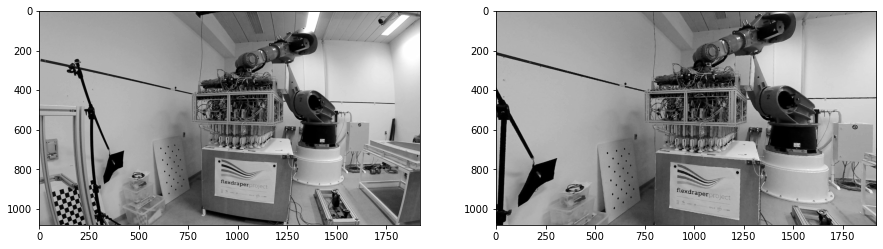

In [330]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(gray, cmap=cm.gray)
ax2.imshow(canvas_matrix, cmap=cm.gray)

(2, 2073600)